In [16]:
# imports
import pathlib, pickle, datetime
from io import BytesIO
import matplotlib.pyplot as plt, numpy as np
from PIL import Image
from IPython.display import Image as display_image
from matplotlib.patches import FancyArrow
from sqlalchemy import create_engine, select, func, not_, inspect
from flyeranalysis.flyer_analysis_entry import FlyerAnalysisEntry
from flyeranalysis.flyer_image_entry import FlyerImageEntry
from flyeranalysis.metadata_link_entry import MetadataLinkEntry
from collections import defaultdict

In [17]:
# frames on which each gif should start and end
START_FRAME = 90
END_FRAME = 256
FRAMES_NB = abs(END_FRAME-START_FRAME)
example_video_metadata_link_id = 125
FEATURES_NB = 6

In [18]:
# read the credentials from the pickle file
flyer_analysis_DB_auth_pickle_file_path = pathlib.Path()/"flyer_analysis_db_auth.pkl"
with open(flyer_analysis_DB_auth_pickle_file_path,"rb") as fp:
    auth = pickle.load(fp)

# connect to the database
db_connection_string = (
    f"mssql+pymssql://{auth['username']}:{auth['password']}"
    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
)
engine = create_engine(db_connection_string)  # ,echo=True)

### Find the total number of images, videos, and the number of videos with at least 50% good frames

In [19]:
stmt = select(func.count()).select_from(FlyerAnalysisEntry)
with engine.connect() as conn:
    n_analysis_results = conn.execute(stmt).all()[0][0]
print(f"Total number of analyzed images = {n_analysis_results}")

stmt = select(func.count()).select_from(FlyerAnalysisEntry).filter(FlyerAnalysisEntry.exit_code==0)
with engine.connect() as conn:
    n_good_analysis_results = conn.execute(stmt).all()[0][0]
print(f"Number of analyzed images with exit code 0 = {n_good_analysis_results}")

Total number of analyzed images = 236652
Number of analyzed images with exit code 0 = 173838


In [20]:
stmt = select(func.count()).select_from(MetadataLinkEntry)
with engine.connect() as conn:
    n_metadata_links = conn.execute(stmt).all()[0][0]
print(f"Total number of videos = {n_metadata_links}")

Total number of videos = 1623


In [7]:
good_video_metadata_link_ids = []
# good_video_metadata_link_ids = {}
with engine.connect() as conn:
    metadata_link_ids = [res.ID for res in conn.execute(select(MetadataLinkEntry.ID)).all()]
for metadata_link_id in metadata_link_ids:
    stmt = (
        select(FlyerAnalysisEntry.exit_code)
        .where(FlyerAnalysisEntry.metadata_link_ID==metadata_link_id)
    )
    with engine.connect() as conn:
        video_exit_codes = [res.exit_code for res in conn.execute(stmt).all()]
    n_total_frames = len(video_exit_codes)
    n_good_frames = video_exit_codes.count(0)
    if (n_good_frames/n_total_frames)>=0.5:
        good_video_metadata_link_ids.append(metadata_link_id)
        # good_video_metadata_link_ids[metadata_link_id].append(metadata_link_id)
print(f"Number of videos with at least 50% good frames = {len(good_video_metadata_link_ids)}")

Number of videos with at least 50% good frames = 778


### An example plot of the analysis results for one video

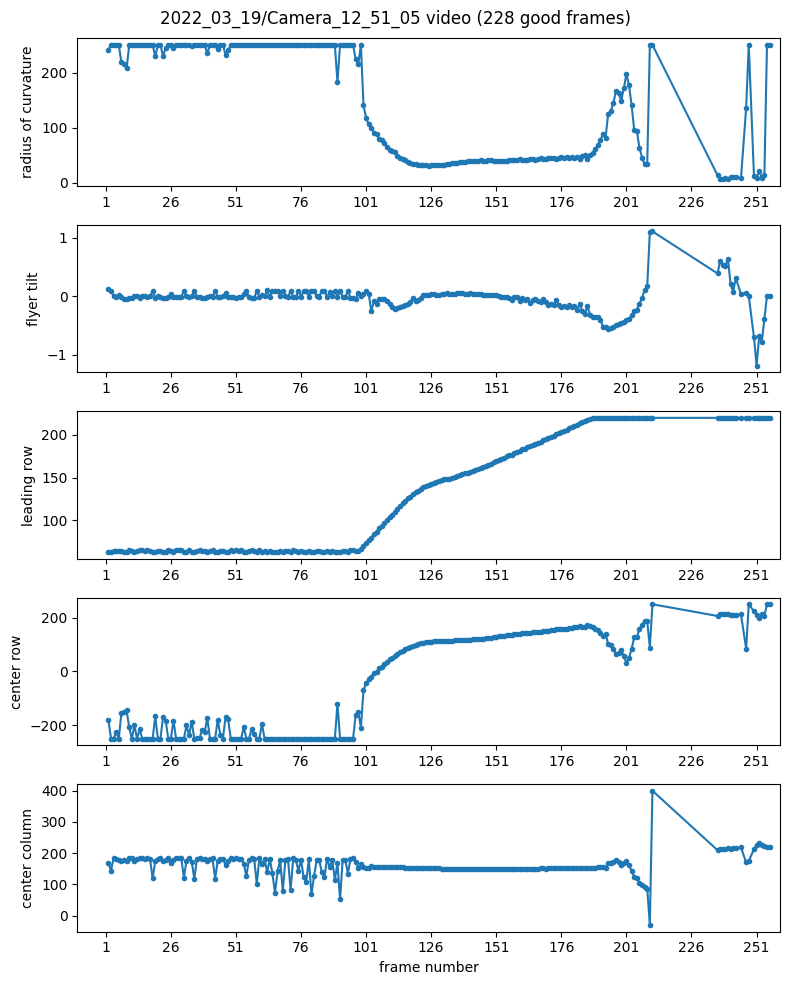

In [23]:
# example_video_metadata_link_id = good_video_metadata_link_ids[int(0.5*len(good_video_metadata_link_ids))]

# get all the analysis results for the example video
stmt = (
    select(
        FlyerAnalysisEntry.rel_filepath,
        FlyerAnalysisEntry.exit_code,
        FlyerAnalysisEntry.radius,
        FlyerAnalysisEntry.tilt,
        FlyerAnalysisEntry.leading_row,
        FlyerAnalysisEntry.center_row,
        FlyerAnalysisEntry.center_column,
    )
    .where(FlyerAnalysisEntry.metadata_link_ID==example_video_metadata_link_id)
    .order_by(FlyerAnalysisEntry.rel_filepath)
)
with engine.connect() as conn:
    video_results = conn.execute(stmt).all()
# count the number of frames with exit code!=0
n_good_frames = len([res for res in video_results if res.exit_code==0])
# create arrays of all of the computed values to plot them
frame_numbers = []
radii = []
tilts = []
leading_rows = []
center_rows = []
center_columns = []
for result in video_results:
    if result.exit_code != 0:
        continue
    frame_number = int(
        result.rel_filepath.split("/")[-1].split("_")[-1][: -len(".bmp")]
    )
    frame_numbers.append(frame_number)
    radii.append(min(result.radius,250.0))
    tilts.append(result.tilt)
    leading_rows.append(result.leading_row)
    center_rows.append(max(-250, min(250, result.center_row)))
    center_columns.append(max(-400, min(400, result.center_column)))
# plot all the computed values as a function of frame number
f, ax = plt.subplots(5, 1, figsize=(8.0, 10.0))
for axs in ax:
    axs.set_xlim((-10, 260))
    axs.set_xticks(list(range(1, 256, 25)))
    axs.set_xticklabels(list(range(1, 256, 25)))
kwargs = {"marker": "."}
ax[0].plot(frame_numbers, radii, **kwargs)
ax[0].set_ylabel("radius of curvature")
ax[1].plot(frame_numbers, tilts, **kwargs)
ax[1].set_ylabel("flyer tilt")
ax[2].plot(frame_numbers, leading_rows, **kwargs)
ax[2].set_ylabel("leading row")
ax[3].plot(frame_numbers, center_rows, **kwargs)
ax[3].set_ylabel("center row")
ax[4].plot(frame_numbers, center_columns, **kwargs)
ax[4].set_ylabel("center column")
ax[4].set_xlabel("frame number")
res = video_results[0]
f.suptitle(f"{res.rel_filepath.split('/')[-4]}/{res.rel_filepath.split('/')[-2]} video ({n_good_frames} good frames)")
f.tight_layout()
# plt.show()
plt.savefig('features_plot.png')

### Selecting some video frames with extreme results and showing their images

In [24]:
def plot_example_result(img_entry,title):
    cam_img = np.asarray(Image.open(BytesIO(img_entry.camera_image)))
    ana_img = np.load(BytesIO(img_entry.analysis_image))["arr_0"]
    padded_ana_img = np.zeros_like(cam_img)
    padded_ana_img[:ana_img.shape[0],:ana_img.shape[1]] = ana_img
    f,ax = plt.subplots(1,3,figsize=(3*5.5,5.5*cam_img.shape[0]/cam_img.shape[1]))
    ax[0].imshow(cam_img,cmap="gray")
    ax[1].imshow(padded_ana_img,interpolation="nearest")
    ax[2].imshow(cam_img,cmap="gray")
    ax[2].imshow(padded_ana_img,interpolation="nearest",alpha=0.5)
    f.suptitle(title)
    for axs in ax:
        axs.axis("off")
    f.tight_layout()
    # plt.show()
    plt.savefig(f'{title}.png')

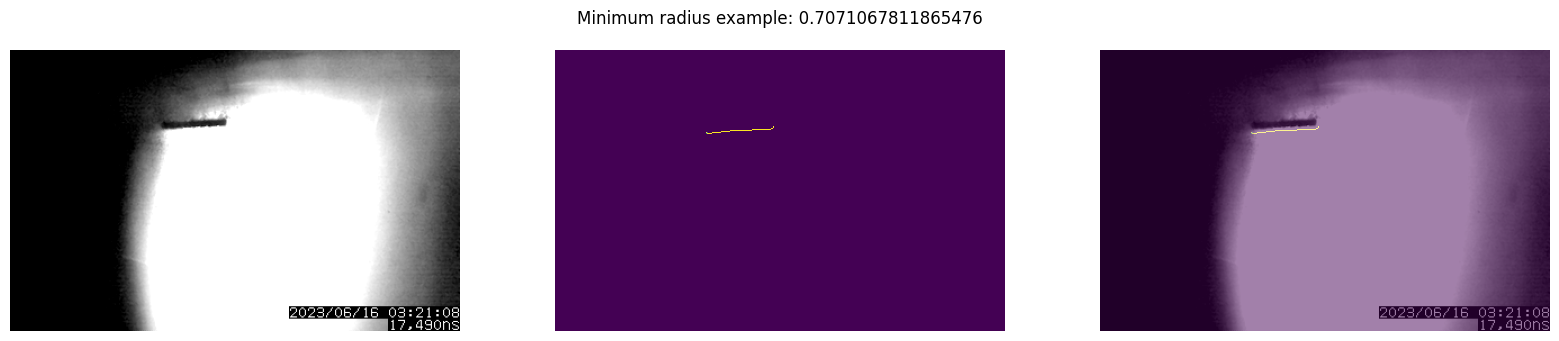

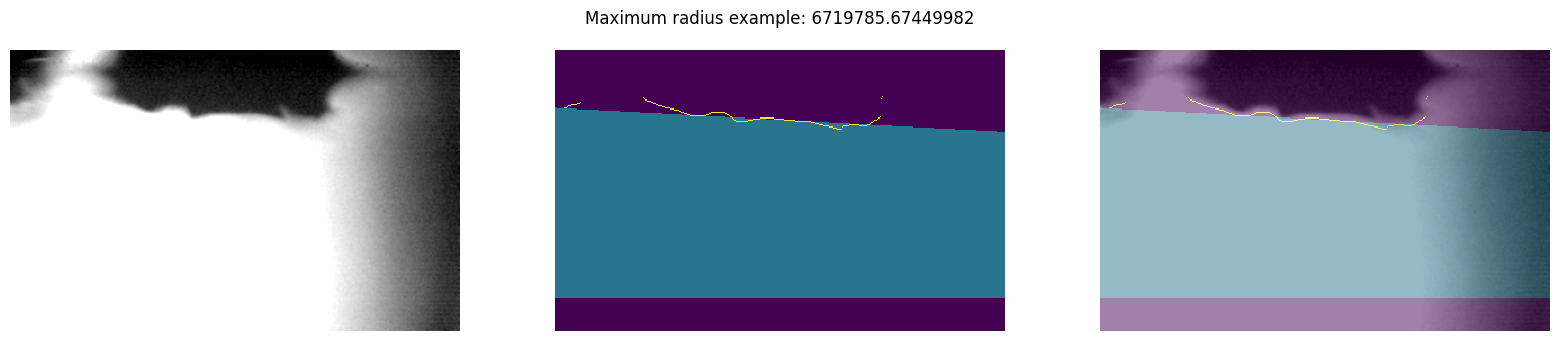

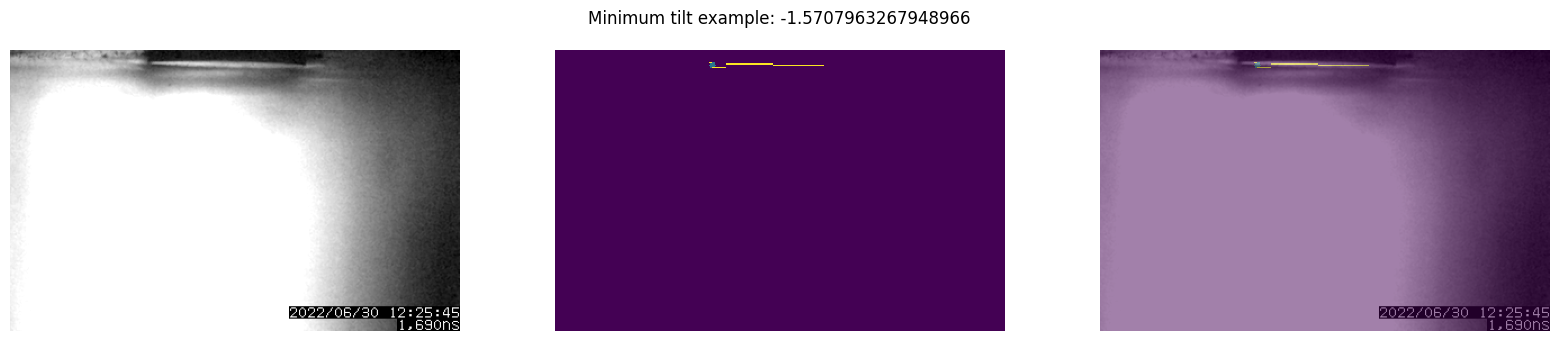

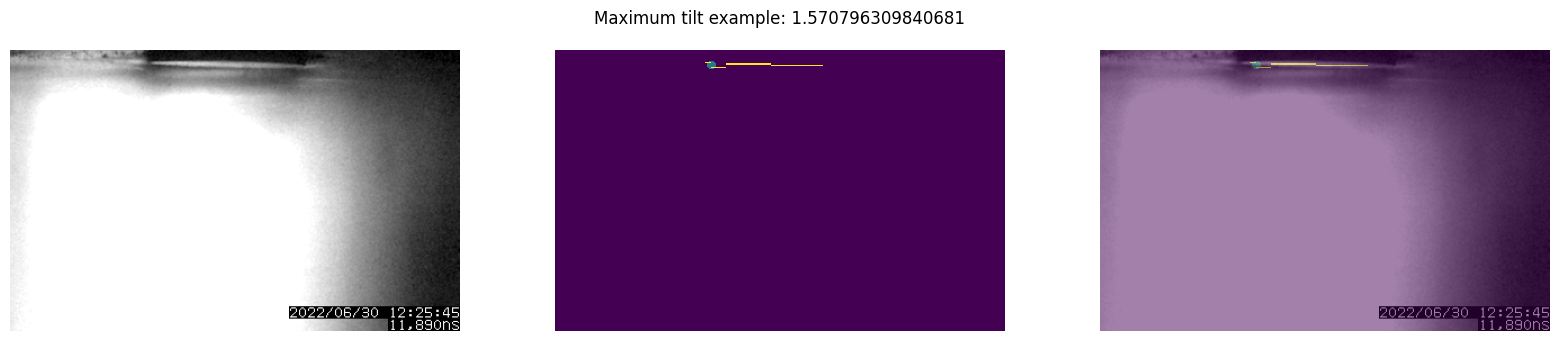

In [25]:
stmt = (
    select(func.min(FlyerAnalysisEntry.radius))
    .select_from(FlyerAnalysisEntry)
    .filter(FlyerAnalysisEntry.exit_code == 0)
)
with engine.connect() as conn:
    min_radius = conn.execute(stmt).first()[0]
stmt = (
    select(FlyerImageEntry)
    .join(FlyerAnalysisEntry)
    .where(FlyerAnalysisEntry.radius == min_radius)
)
with engine.connect() as conn:
    img_entry = conn.execute(stmt).first()
plot_example_result(img_entry, f"Minimum radius example: {min_radius}")

stmt = (
    select(func.max(FlyerAnalysisEntry.radius))
    .select_from(FlyerAnalysisEntry)
    .filter(
        (FlyerAnalysisEntry.exit_code == 0)
        & not_(FlyerAnalysisEntry.rel_filepath.contains("TC--"))
    )
)
with engine.connect() as conn:
    max_radius = conn.execute(stmt).first()[0]
stmt = (
    select(FlyerImageEntry)
    .join(FlyerAnalysisEntry)
    .where(FlyerAnalysisEntry.radius == max_radius)
)
with engine.connect() as conn:
    img_entry = conn.execute(stmt).first()
plot_example_result(img_entry, f"Maximum radius example: {max_radius}")

stmt = (
    select(func.min(FlyerAnalysisEntry.tilt))
    .select_from(FlyerAnalysisEntry)
    .filter(FlyerAnalysisEntry.exit_code == 0)
)
with engine.connect() as conn:
    min_tilt = conn.execute(stmt).first()[0]
stmt = (
    select(FlyerImageEntry)
    .join(FlyerAnalysisEntry)
    .where(FlyerAnalysisEntry.tilt == min_tilt)
)
with engine.connect() as conn:
    img_entry = conn.execute(stmt).first()
plot_example_result(img_entry, f"Minimum tilt example: {min_tilt}")

stmt = (
    select(func.max(FlyerAnalysisEntry.tilt))
    .select_from(FlyerAnalysisEntry)
    .filter(
        (FlyerAnalysisEntry.exit_code == 0)
        & not_(FlyerAnalysisEntry.rel_filepath.contains("TC--"))
    )
)
with engine.connect() as conn:
    max_tilt = conn.execute(stmt).first()[0]
stmt = (
    select(FlyerImageEntry)
    .join(FlyerAnalysisEntry)
    .where(FlyerAnalysisEntry.tilt == max_tilt)
)
with engine.connect() as conn:
    img_entry = conn.execute(stmt).first()
plot_example_result(img_entry, f"Maximum tilt example: {max_tilt}")

### Make an example gif for a video right out of what's in the DB

In [26]:
stmt = (
    select(
        FlyerAnalysisEntry.rel_filepath,
        FlyerAnalysisEntry.exit_code,
        FlyerAnalysisEntry.center_row,
        FlyerAnalysisEntry.center_column,
        FlyerImageEntry.camera_image,
        FlyerImageEntry.analysis_image,
    )
    .join(FlyerImageEntry)
    .where(
        (FlyerAnalysisEntry.metadata_link_ID==example_video_metadata_link_id)
        & (not_(FlyerAnalysisEntry.rel_filepath.contains("TC--")))
    )
    .order_by(FlyerAnalysisEntry.rel_filepath)
)
with engine.connect() as conn:
    video_results = conn.execute(stmt).all()
gif_title = "/".join(video_results[0].rel_filepath.split('/')[-3:-1])
# create a gif frame from each original frame in the video
gif_frame_bytestrings = []
for result in video_results:
    # get the frame number and make sure it's in range
    frame_number = int(
        result.rel_filepath.split("/")[-1].split("_")[-1][: -len(".bmp")]
    )
    if frame_number not in range(START_FRAME, END_FRAME + 1):
        continue
    # convert the original image to a numpy array
    original_image = np.asarray(Image.open(BytesIO(result.camera_image)))
    # if the frame didn't have a good result, just use the original grayscale image
    if result.analysis_image is None:
        frame_stream = BytesIO()
        f, ax = plt.subplots()
        ax.imshow(original_image, cmap="gray")
        ax.set_title(gif_title)
        ax.axis("off")
        plt.savefig(frame_stream, bbox_inches="tight")
        plt.close()
        frame_stream.seek(0)
        gif_frame_bytestrings.append(frame_stream.read())
        continue
    # if the result was good, though, create an overlay from the result
    analysis_image = np.load(BytesIO(result.analysis_image))["arr_0"]
    flyer_row, flyer_col = np.nonzero(np.where(analysis_image > 200, 1, 0))
    analysis_overlay = np.zeros_like(original_image)
    analysis_overlay[: analysis_image.shape[0], :] = analysis_image
    arrow = FancyArrow(
        np.median(flyer_col),
        np.median(flyer_row),
        0.75 * (result.center_column - np.mean(flyer_col)),
        0.75 * (result.center_row - np.mean(flyer_row)),
        width=0.1,
        color="r",
    )
    frame_stream = BytesIO()
    f, ax = plt.subplots()
    ax.imshow(original_image, cmap="gray")
    analysis_im_alphas = 0.5 * np.ones_like(analysis_overlay)
    analysis_im_alphas[analysis_overlay == 0] = 0
    ax.imshow(analysis_overlay, alpha=analysis_im_alphas)
    ax.add_patch(arrow)
    ax.set_title(gif_title)
    ax.axis("off")
    plt.savefig(frame_stream, bbox_inches="tight")
    plt.close()
    frame_stream.seek(0)
    gif_frame_bytestrings.append(frame_stream.read())
gif_stream = BytesIO()
gif_frames = [
    Image.open(BytesIO(frame_bytestring))
    for frame_bytestring in gif_frame_bytestrings
]
frame_one = gif_frames[0]
frame_one.save(
    gif_stream,
    format="GIF",
    append_images=gif_frames,
    save_all=True,
    duration=100,
    loop=0,
)
gif_stream.seek(0)
# display(display_image(data=gif_stream.read()))
with open('video.gif', 'wb') as file:
    file.write(gif_stream.read())


### Plot the number of good frames in each video as a function of timestamp

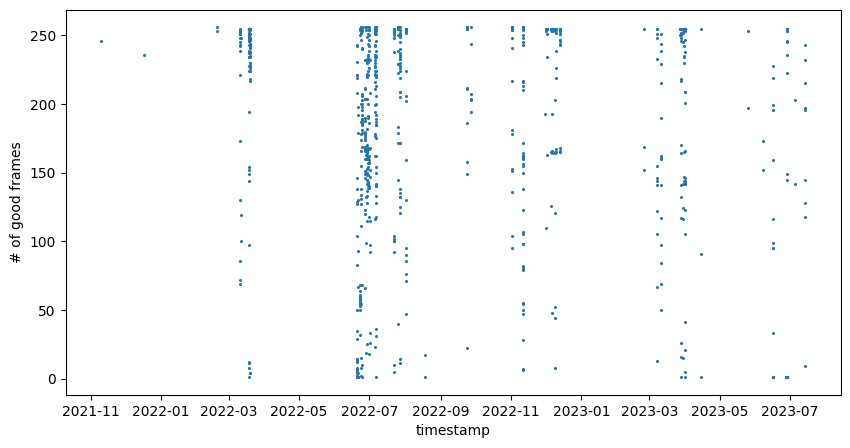

In [12]:
# get the number of good frames for each metadata link ID
stmt = (
    select(FlyerAnalysisEntry.metadata_link_ID,func.count())
    .select_from(FlyerAnalysisEntry)
    .filter(FlyerAnalysisEntry.exit_code==0)
    .group_by(FlyerAnalysisEntry.metadata_link_ID)
    .order_by(FlyerAnalysisEntry.metadata_link_ID)
)
with engine.connect() as conn:
    n_good_frames_by_metadata_link_id = {res[0]:res[1] for res in conn.execute(stmt).all()}

# # There are some entries that have more than the maximum number of good video frames
# # These need to be associated with FileMaker DB entries in some more complex way
# weird_mlids = []
# for mlid,ngf in n_good_frames_by_metadata_link_id.items():
#     if ngf>256:
#         print(f"entry {mlid}: {ngf} good frames")
#         weird_mlids.append(mlid)
# stmt = select(MetadataLinkEntry).where(MetadataLinkEntry.ID.in_(weird_mlids))
# with engine.connect() as conn:
#     results = conn.execute(stmt).mappings().all()
# for res in results:
#     print(res)
# # Checking the relative filepaths for one of those glitched metadata link entries
# stmt = select(FlyerAnalysisEntry.rel_filepath).where(FlyerAnalysisEntry.metadata_link_ID==weird_mlids[0])
# with engine.connect() as conn:
#     results = conn.execute(stmt).all()
# for res in results:
#     print(res[0])

# get a full timestamp for each metadata link ID
stmt = (
    select(
        MetadataLinkEntry.ID,
        MetadataLinkEntry.datestamp,
        MetadataLinkEntry.experiment_day_counter,
        MetadataLinkEntry.camera_filename
    )
    .where(MetadataLinkEntry.datestamp.isnot(None))
    .order_by(MetadataLinkEntry.ID)
)
with engine.connect() as conn:
    results = conn.execute(stmt).mappings().all()
timestamps_by_metadata_link_id = {}
for result in results:
    datestamp = result["datestamp"]
    if result["camera_filename"]:
        timestamp = datetime.datetime.strptime(result["camera_filename"],"%H_%M_%S").time()
    elif result["experiment_day_counter"]:
        counter = int(result["experiment_day_counter"])
        hour = int(counter/2)
        mins = 30*(counter%2)
        timestamp = datetime.time(hour,mins)
    full_timestamp = datestamp.combine(datestamp,timestamp)
    timestamps_by_metadata_link_id[result["ID"]] = full_timestamp
# make the plot
timestamps = []
ns_good_frames = []
for metadata_link_id,timestamp in timestamps_by_metadata_link_id.items():
    if metadata_link_id not in n_good_frames_by_metadata_link_id:
        continue
    # skip entries with more than the total number of frames (timestamps for these are bugged)
    if n_good_frames_by_metadata_link_id[metadata_link_id]>256:
        continue
    timestamps.append(timestamp)
    ns_good_frames.append(n_good_frames_by_metadata_link_id[metadata_link_id])
f,ax = plt.subplots(figsize=(10.,5.))
ax.scatter(timestamps,ns_good_frames,marker="o",s=(120./f.dpi)**2)
ax.set_xlabel("timestamp")
ax.set_ylabel("# of good frames")
plt.show()

In [13]:
# mant filemaker records omitted this field
stmt = select(MetadataLinkEntry).filter(MetadataLinkEntry.camera_filename!=None) #.order_by(FlyerAnalysisEntry.metadata_link_ID)
with engine.connect() as conn:
    result = conn.execute(stmt).all()
    print(len(result))
    print(result[0])

940
(2, None, None, '15_21_08')


### Attempt to predict whether a video is good or bad based on all of its frames (Incomplete)

In [14]:
from collections import defaultdict

print(good_video_metadata_link_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 69, 70, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 781, 784, 785, 788, 789, 790, 791, 792, 793, 795, 796, 798, 799, 801, 802, 803, 812, 831, 837, 838, 845, 847, 848, 861, 862, 864, 865, 866, 867, 869, 871, 874, 875, 876, 894, 895, 904, 906, 907, 908, 915, 916, 917, 919, 920, 923, 924, 925, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 980, 981, 

In [15]:
print(f"length before removing zero elements: {len(X)} and {len(Y)}")
for key in list(X.keys()):
    my_array = X[key]
    zero_rows_count = np.count_nonzero(np.all(my_array == 0, axis=1))
    # print(f"nb of empty rows: {zero_rows_count}")
    if zero_rows_count > 0:
        X.pop(key)
        Y.pop(key)
print(f"length after removing zero elements: {len(X)} and {len(Y)}")


NameError: name 'X' is not defined